In [18]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from functools import partial

import optax

In [19]:
@jax.jit
def log_psi(alpha, x):
    log_psi = -alpha * x ** 2 / 2
    return log_psi

In [20]:
log_prob = jax.jit(lambda alpha, x: 2 * log_psi(alpha, x))

In [51]:
def mcmc_step(alpha, key, position, step_size):
    """
    A single step of the Metropolis-Hastings algorithm.
    """
    key, subkey = jax.random.split(key)
    # Sample a new position from the proposal distribution
    new_position = position + jax.random.normal(subkey, position.shape) * step_size
    # Compute the log-probability of the new position
    new_log_prob = log_prob(alpha, new_position)
    # Compute the log-probability of the old position
    old_log_prob = log_prob(alpha, position)
    # Compute the log-acceptance ratio
    log_acceptance_ratio = new_log_prob - old_log_prob
    # Accept or reject the new position
    key, subkey = jax.random.split(key)
    accept = jnp.log(jax.random.uniform(subkey, (position.shape[0],))) < log_acceptance_ratio
    return new_position * accept + position * (1 - accept), key, jnp.sum(accept)/position.shape[0]

In [23]:
dlog_psi = jax.jit(jax.grad(log_psi, argnums=(1)))
d2log_psi = jax.jit(jax.grad(jax.grad(log_psi, argnums=(1)), argnums=(1)))

In [24]:
local_energy = jax.jit(jax.vmap(lambda alpha, x:
    -(dlog_psi(alpha, x)**2 + d2log_psi(alpha, x)) / 2 + 1 / 2 * x ** 2, in_axes=(None, 0)))

In [25]:
energy = jax.jit(lambda alpha, x: jnp.mean(local_energy(alpha, x)))
energy_var = jax.jit(lambda alpha, x: jnp.var(local_energy(alpha, x)))
energy_grad = jax.jit(jax.grad(energy, argnums=(0)))

In [66]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
n_walkers = 1000
position = jax.random.normal(subkey, (n_walkers,))
step_size = 2
n_steps = 30
burn_in = 1000
alpha = 0.5

alpha_list = []
energy_list = []
energy_grad_list = []
energy_var_list = []

optimizer = optax.adam(1e-1)
opt_state = optimizer.init(alpha)

for i in range(n_steps):
    for j in range(burn_in):
        position, key, ac_ratio = mcmc_step(alpha, key, position, step_size)
        # print(ac_ratio)
    alpha_list.append(alpha)
    energy_list.append(energy(alpha, position))
    energy_grad_list.append(energy_grad(alpha, position))
    energy_var_list.append(energy_var(alpha, position))
    updates, opt_state = optimizer.update(energy_grad(alpha, position), opt_state)
    alpha = optax.apply_updates(alpha, updates)
    print(i, energy(alpha, position))

0 0.62988275
1 0.57107294
2 0.533632
3 0.5097534
4 0.50419074
5 0.5030281
6 0.50034046
7 0.49918702
8 0.49914968
9 0.4966009
10 0.5093795
11 0.5104819
12 0.5053191
13 0.50620705
14 0.51802486
15 0.5153177
16 0.50911456
17 0.51094496
18 0.50321424
19 0.5038788
20 0.5045793
21 0.50650436
22 0.50386614
23 0.5049409
24 0.50297034
25 0.50081605
26 0.49987727
27 0.5003359
28 0.49994907
29 0.4996459


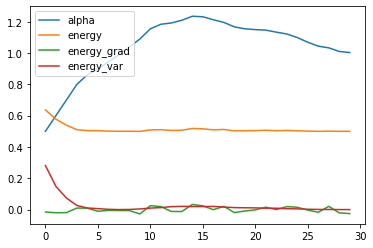

In [67]:
plt.plot(alpha_list, label='alpha')
plt.plot(energy_list, label='energy')
plt.plot(energy_grad_list, label='energy_grad')
plt.plot(energy_var_list, label='energy_var')
plt.legend()
plt.show()